# Getting temp data from .nc files at locations of interest


In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import geopandas as gpd

/home/caprice/micromamba/envs/summerfog/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


files = sorted(glob.glob("*.nc"))
files

In [5]:

#correct format is: "/mnt/c/Users/isabe/FILES/Documents/FHL Summer 2025/2022-09-29T19_01_47.715049000.nc"

#fn = '2019-08-28T19:01:37.429983000.nc'

fn = '2019-08-12T19:01:33.400679000.nc'


In [6]:
ds = xr.open_dataset(fn)

In [7]:
ds


<xarray.Dataset> Size: 149MB
Dimensions:           (y: 1974, x: 1675)
Coordinates:
  * y                 (y) float64 16kB 5.42e+06 5.42e+06 ... 5.361e+06 5.361e+06
  * x                 (x) float64 13kB 4.75e+05 4.751e+05 ... 5.253e+05
    time              datetime64[ns] 8B ...
Data variables: (12/21)
    spatial_ref       int32 4B ...
    qa                (y, x) int16 7MB ...
    red               (y, x) uint16 7MB ...
    blue              (y, x) uint16 7MB ...
    drad              (y, x) int16 7MB ...
    emis              (y, x) int16 7MB ...
    ...                ...
    swir22            (y, x) uint16 7MB ...
    coastal           (y, x) uint16 7MB ...
    qa_pixel          (y, x) uint16 7MB ...
    qa_radsat         (y, x) uint16 7MB ...
    qa_aerosol        (y, x) uint8 3MB ...
    temperature_degC  (y, x) float64 26MB ...

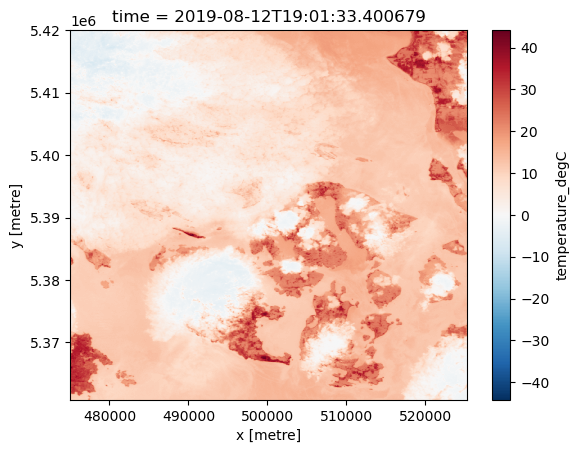

In [8]:
ds['temperature_degC'].plot()

#can plot any of variables listed above 
#cattle point coords: 48.465113, -122.952554





# Converting from LatLong to UMT coords for difference SST locations

In [3]:
#from chatgpt i think?

#this code converts from latlong
#got this point from google maps off of CP, had to convert from latlong (WGS84) (world geodetic system 1984) into UTM 10-N
#important to note: latlong is EPSG:4326, UTM is EPSG:32610
#UTM 10N is specifically western washington + a little more
from shapely.geometry import Point
#Point has functions like buffer, etc, which we used to make circle
#shapely is vector data
import geopandas as gpd 

# Define the lat/lon point
lat_lon_point = Point(-123.009148, 48.543532)

#FHL SJ Channel: (-122.999792, 48.549525)
#FHL Harbor: (-123.009148, 48.543532)
#Cattle Point: (-122.952554, 48.465113)

# Create a GeoDataFrame with the point and its original CRS (EPSG:4326)
gdf = gpd.GeoDataFrame(geometry=[lat_lon_point], crs="EPSG:4326")
#geopandas is able to convert btwn coords pretty easily, so made a GeoDataFrame for that reason only - csv with 1 item in it, essentially

# Reproject the GeoDataFrame to the target CRS (EPSG:32610)
gdf_reprojected = gdf.to_crs("EPSG:32610")
#coordinate reference system

# Extract the reprojected point
reprojected_point = gdf_reprojected.geometry[0]
print(reprojected_point)

POINT (499324.7991388869 5376714.459432317)


In [4]:
reprojected_point.x

499324.7991388869

In [11]:
#extracting data from a single point
#
ds.interp(x=reprojected_point.x, y=reprojected_point.y, method='nearest') #nearest vs linear = method used to get values at point from gridded data set

<xarray.Dataset> Size: 188B
Dimensions:           ()
Coordinates:
    time              datetime64[ns] 8B ...
    x                 float64 8B 5.035e+05
    y                 float64 8B 5.368e+06
Data variables: (12/21)
    spatial_ref       int32 4B ...
    qa                float64 8B 377.0
    red               float64 8B 7.326e+03
    blue              float64 8B 7.618e+03
    drad              float64 8B 985.0
    emis              float64 8B 9.88e+03
    ...                ...
    swir22            float64 8B 7.478e+03
    coastal           float64 8B 7.428e+03
    qa_pixel          float64 8B 2.195e+04
    qa_radsat         float64 8B 0.0
    qa_aerosol        float64 8B 228.0
    temperature_degC  float64 8B 12.14

In [12]:
ds

<xarray.Dataset> Size: 149MB
Dimensions:           (y: 1974, x: 1675)
Coordinates:
  * y                 (y) float64 16kB 5.42e+06 5.42e+06 ... 5.361e+06 5.361e+06
  * x                 (x) float64 13kB 4.75e+05 4.751e+05 ... 5.253e+05
    time              datetime64[ns] 8B ...
Data variables: (12/21)
    spatial_ref       int32 4B ...
    qa                (y, x) int16 7MB ...
    red               (y, x) uint16 7MB ...
    blue              (y, x) uint16 7MB ...
    drad              (y, x) int16 7MB ...
    emis              (y, x) int16 7MB ...
    ...                ...
    swir22            (y, x) uint16 7MB ...
    coastal           (y, x) uint16 7MB ...
    qa_pixel          (y, x) uint16 7MB ...
    qa_radsat         (y, x) uint16 7MB ...
    qa_aerosol        (y, x) uint8 3MB ...
    temperature_degC  (y, x) float64 26MB ...

<Axes: title={'center': 'spatial_ref = 0, time = 2019-08-12T19:01:33.400679'}, xlabel='x [metre]', ylabel='y [metre]'>

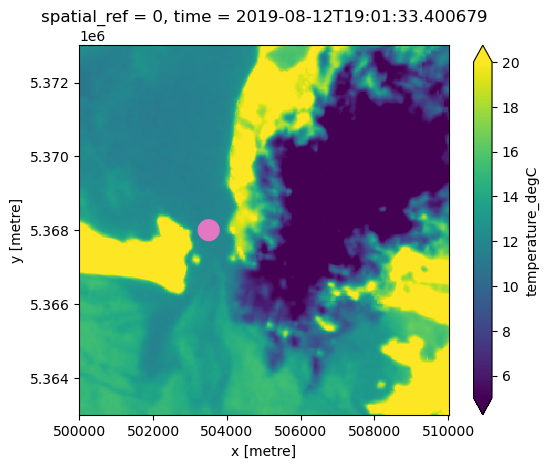

In [21]:
#extracting data for an area
#using a buffer function 
#.buffer() makes a polygon
#again, using GeoDataFrame as a convenient way to do things - table w/ one item in it
gdf = gpd.GeoDataFrame(
    geometry=[reprojected_point.buffer(300)], 
    crs="EPSG:32610"
)


fig, ax = plt.subplots()
ds['temperature_degC'].loc[5.373e6:5.363e6, 5.0e5:5.10e5].plot(ax = ax, vmin=5, vmax=20)
#plt.ylim(5.36e6, 5.37e6)

gdf.plot(ax = ax, color='tab:pink')
#using gdf to plot

In [14]:
ds

<xarray.Dataset> Size: 149MB
Dimensions:           (y: 1974, x: 1675)
Coordinates:
  * y                 (y) float64 16kB 5.42e+06 5.42e+06 ... 5.361e+06 5.361e+06
  * x                 (x) float64 13kB 4.75e+05 4.751e+05 ... 5.253e+05
    time              datetime64[ns] 8B ...
Data variables: (12/21)
    spatial_ref       int32 4B ...
    qa                (y, x) int16 7MB ...
    red               (y, x) uint16 7MB ...
    blue              (y, x) uint16 7MB ...
    drad              (y, x) int16 7MB ...
    emis              (y, x) int16 7MB ...
    ...                ...
    swir22            (y, x) uint16 7MB ...
    coastal           (y, x) uint16 7MB ...
    qa_pixel          (y, x) uint16 7MB ...
    qa_radsat         (y, x) uint16 7MB ...
    qa_aerosol        (y, x) uint8 3MB ...
    temperature_degC  (y, x) float64 26MB ...

In [22]:
ds = ds.rio.write_crs('EPSG:32610')
#in order to use rio.clip, needed to make sure that ds had "i am in UTM coords" written in the right place
#so write_crs does that for us


In [23]:
dsclipped = ds.rio.clip(gdf.geometry, all_touched=True)
#clipping all data to just the circle and getting what's inside
#getting rid of all_touched=True makes it default False

/home/caprice/micromamba/envs/summerfog/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:253: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


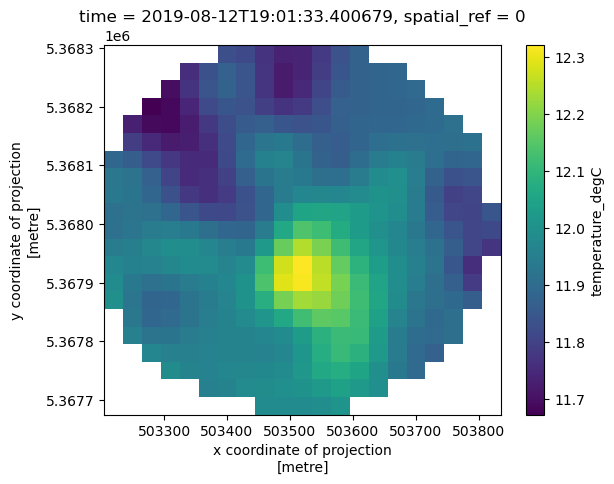

In [24]:
dsclipped['temperature_degC'].plot()
#plotting!

In [18]:
#dsclipped.temperature_celsius.mean(dim=["x", "y"])
dsclipped.mean(dim=["x", "y"])

<xarray.Dataset> Size: 176B
Dimensions:           ()
Coordinates:
    time              datetime64[ns] 8B ...
    spatial_ref       int64 8B 0
Data variables: (12/20)
    qa                float64 8B -1.739e+03
    red               float64 8B 5.784e+03
    blue              float64 8B 6.085e+03
    drad              float64 8B -1.256e+03
    emis              float64 8B 5.823e+03
    emsd              float64 8B -2.041e+03
    ...                ...
    swir22            float64 8B 5.852e+03
    coastal           float64 8B 5.952e+03
    qa_pixel          float64 8B 1.747e+04
    qa_radsat         float64 8B 0.0
    qa_aerosol        float64 8B 178.8
    temperature_degC  float64 8B 11.93

In [82]:
dsclipped

<xarray.Dataset> Size: 36kB
Dimensions:           (y: 28, x: 28)
Coordinates:
  * y                 (y) float64 224B 5.368e+06 5.368e+06 ... 5.368e+06
  * x                 (x) float64 224B 5.031e+05 5.031e+05 ... 5.039e+05
    time              datetime64[ns] 8B ...
    spatial_ref       int64 8B 0
Data variables: (12/20)
    qa                (y, x) int16 2kB -9999 -9999 -9999 ... -9999 -9999 -9999
    red               (y, x) uint16 2kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    blue              (y, x) uint16 2kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    drad              (y, x) int16 2kB -9999 -9999 -9999 ... -9999 -9999 -9999
    emis              (y, x) int16 2kB -9999 -9999 -9999 ... -9999 -9999 -9999
    emsd              (y, x) int16 2kB -9999 -9999 -9999 ... -9999 -9999 -9999
    ...                ...
    swir22            (y, x) uint16 2kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    coastal           (y, x) uint16 2kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    qa_pixel          (y, x) uint16 2kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    qa_radsat         (y, x) uint16 2kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    qa_aerosol        (y, x) uint8 784B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    temperature_degC  (y, x) float64 6kB nan nan nan nan nan ... nan nan nan nan